In [ ]:
# Imp Uncomment when running on colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray,gray2rgb
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, image_id,mask_id ,root_dir, transform = None):

        self.image_id = image_id
        self.mask_id = mask_id
        self.transform = transform
        self.root_dir = root_dir

        self.dataset_path = root_dir + "data_set/"
        self.mask_path = root_dir + "masks/"

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, index):
        image_name = self.image_id[index]
        image_path = os.path.join(self.dataset_path, image_name)
        
        img = io.imread(image_path)
        img = resize(img, (256, 256))
        originalImg = torch.from_numpy(img) # Converting to Torch Format
        originalImg = originalImg.permute(2,1,0) # Moving the order to Channel, Width and Height
        
        mask_name = self.mask_id[index]
        mask_path = os.path.join(self.mask_path, mask_name)
        
        mask = io.imread(mask_path+".png")
  
        mask = (mask > 125)

        mask = resize(mask, (256, 256))
        maskIm = torch.from_numpy(mask)
       
        maskIm = maskIm.unsqueeze_(-1)
        maskIm  = maskIm.permute(2, 1, 0)

        mask = mask.astype('uint8')
        dst = cv2.bitwise_or(img ,img,mask=mask)
       
        impaintedImg = torch.from_numpy(dst)
        impaintedImg  = impaintedImg.permute(2, 1, 0)

        if self.transform:
            originalImg = self.transform(originalImg)
 
            impaintedImg = self.transform(impaintedImg)

        return originalImg,maskIm,impaintedImg

In [ ]:
train_id = []
mask_id = []

train_id = os.listdir("/content/drive/MyDrive/data_set") # To load image names from the directory

for i in range(1,10244): # 10244 masks in the directory
    mask_id_name =  "mask" + str(i)
    mask_id.append(mask_id_name)

my_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.6122, 0.5436, 0.5247], std=[0.2969, 0.3119, 0.3312])
])

# Ignore for now
batch_size = 8
learning_rate = 3e-4
num_epoch = 100

train_dataset = CustomDataSet(image_id=train_id,mask_id = mask_id, root_dir="/content/drive/MyDrive/", transform=my_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

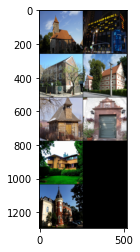

In [ ]:
#writer = SummaryWriter(f'/content/drive/MyDrive/')

## ------------- To fit single batch

#%reload_ext tensorboard
#%tensorboard --logdir '/content/drive/MyDrive/'

(data,maskIm,targets) = next(iter(train_loader))

maskIm = maskIm.type(torch.float)
targets = targets.type(torch.float)
data = data.type(torch.float)

grid_data = torchvision.utils.make_grid(data, nrow=5)
plt.imshow(grid_data.permute(2, 1, 0))

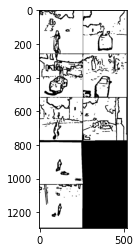

In [ ]:
grid_mask = torchvision.utils.make_grid(maskIm, nrow=5)
plt.imshow(grid_mask.permute(2, 1, 0))

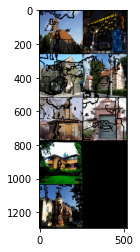

In [ ]:
grid_mask = torchvision.utils.make_grid(targets, nrow=5)
plt.imshow(grid_mask.permute(2, 1, 0))